In [4]:
import Locate_Ice_Mosaic
from Locate_Ice_Mosaic import M3_Mosaic
from os import path as path
import os
import tifffile as tf

ice_pipe_folder = 'D:/Data/Ice_Pipeline_Out_6-2-23'
smooth_folder = path.join(ice_pipe_folder,'rfl_smooth')

in_dict = {}
prog,tot = 1,len(os.listdir(smooth_folder))
for file in os.listdir(smooth_folder):
    im = tf.imread(path.join(smooth_folder,file))
    in_dict.update({file[:-4]:im})
    print (f'\r{prog} of {tot} ({prog/tot:.1%})',end='\r')
    prog+=1

In [100]:
from importlib import reload
reload(Locate_Ice_Mosaic)
from Locate_Ice_Mosaic import M3_Mosaic


def load_tifs(pathList:list)->list:
    tif_list = []
    prog,tot = 1,len(pathList)
    for path in pathList:
        tif_list.append(tf.imread(path))
        print (f'\r{prog} of {tot} retrived. ({prog/tot:.0%})',end='\r')
        prog+=1
    return tif_list

print ('Select Analysis Folder:')
folderPath = 'D:/Data/Ice_Pipeline_Out_6-2-23'
all_rfl_paths = [os.path.join(folderPath,'rfl_cropped',i) for i in os.listdir(os.path.join(folderPath,'rfl_cropped'))]
all_loc_paths = [os.path.join(folderPath,'loc_cropped',i) for i in os.listdir(os.path.join(folderPath,'loc_cropped'))]
all_obs_paths = [os.path.join(folderPath,'obs_cropped',i) for i in os.listdir(os.path.join(folderPath,'obs_cropped'))]

with open(os.path.join(folderPath,'stampNames.txt')) as f:
    all_names = f.readlines()
all_names = [i[:-2] for i in all_names]

def batch_list(input:list,n:int)->list:
    return [input[i:i+n] for i in range(0,len(input),n)]


N = 5
batch_rfl_paths = batch_list(all_rfl_paths,N)
batch_loc_paths = batch_list(all_loc_paths,N)
batch_obs_paths = batch_list(all_obs_paths,N)
all_names_split = batch_list(all_names,N)
batch_keys = batch_list(tuple(in_dict.keys()),N)
batch_vals = batch_list(tuple(in_dict.values()),N)


prog,tot=0,len(all_rfl_paths)
for n in range(len(batch_rfl_paths)):
    print ('Retrieving RFL Tifs...')
    batch_rfl = load_tifs(batch_rfl_paths[n])
    print ('\nRetrieving LOC Tifs...')
    batch_loc = load_tifs(batch_loc_paths[n])
    print ('\nRetrieving OBS Tifs...')
    batch_obs = load_tifs(batch_obs_paths[n])
    batch_names = all_names_split[n]

    batch_dict = {key:val for key,val in zip(batch_keys[n],batch_vals[n])}
    print(batch_dict.keys())

    batchMosaic = M3_Mosaic(batch_rfl,batch_loc,batch_obs,batch_names,folderPath)
    prog = prog+len(batchMosaic.stampNames)
    print (f'\n-----Beginning Mosaic analysis of {len(batchMosaic.stampNames)} ({prog} of {tot})images-----')
    print ('locating ice...')
    allband_array = batchMosaic.locate_ice(inputImageDictionary=batch_dict)

    print ('\nRemoval from memory...')
    del batch_rfl,batch_loc,batch_obs

Select Analysis Folder:
Retrieving RFL Tifs...
5 of 5 retrived. (100%)
Retrieving LOC Tifs...
5 of 5 retrived. (100%)
Retrieving OBS Tifs...
dict_keys(['20090520t065048_smooth', '20090528t083319_smooth', '20090529t013507_smooth', '20090529t100749_smooth', '20090529t183825_smooth'])

-----Beginning Mosaic analysis of 5 (5 of 99)images-----
locating ice...
>>>Ice located in 22.7 seconds

Removal from memory...
Retrieving RFL Tifs...
5 of 5 retrived. (100%)
Retrieving LOC Tifs...
5 of 5 retrived. (100%)
Retrieving OBS Tifs...
dict_keys(['20090530t030925_smooth', '20090530t201123_smooth', '20090531t172712_smooth', '20090601t061442_smooth', '20090602t074711_smooth'])

-----Beginning Mosaic analysis of 5 (10 of 99)images-----
locating ice...
>>>Ice located in 15.5 seconds

Removal from memory...
Retrieving RFL Tifs...
5 of 5 retrived. (100%)
Retrieving LOC Tifs...
5 of 5 retrived. (100%)
Retrieving OBS Tifs...
dict_keys(['20090602t203342_smooth', '20090603t050442_smooth', '20090603t174502_sm

In [95]:
allband_array

(3585, 304, 59)

(3585, 304, 59)


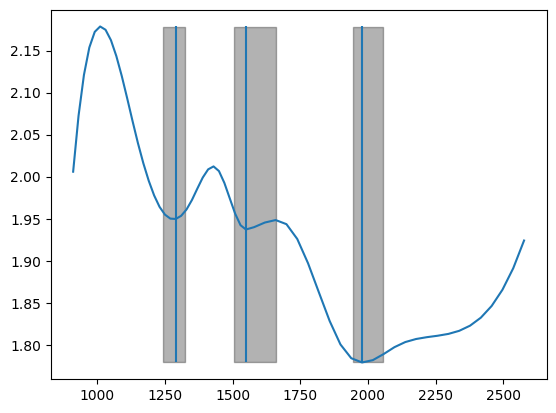

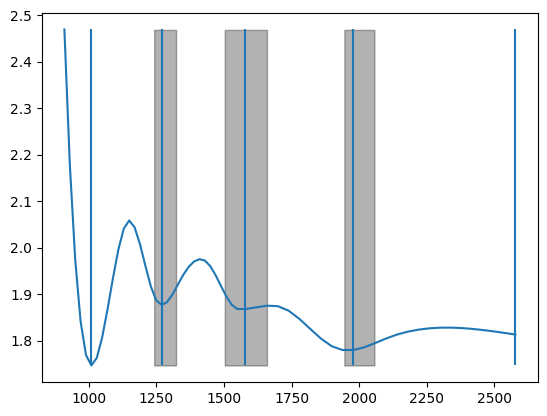

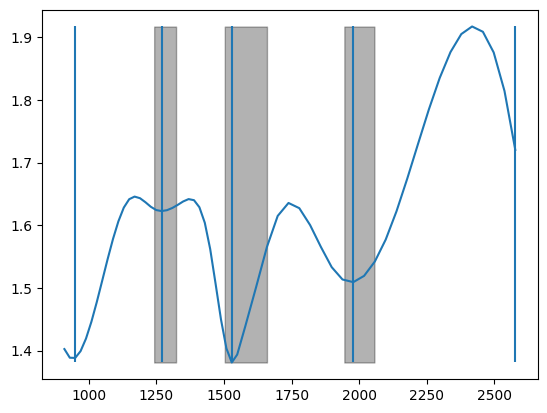

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
print (allband_array.shape)
df = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-2-23/bandInfo.csv')
wvl = df.iloc[:,2]
def plot_stuff(x,y):
    fig = plt.figure()
    test_spec = list(in_dict.values())[0][x,y,:]
    plt.plot(wvl,test_spec)
    plt.vlines(wvl[np.where(allband_array[x,y,:]==1)[0]],test_spec.min(),test_spec.max())
    plt.fill_betweenx(np.arange(test_spec.min(),test_spec.max(),0.001),1242,1323,color='k',alpha=0.3)
    plt.fill_betweenx(np.arange(test_spec.min(),test_spec.max(),0.001),1503,1659,color='k',alpha=0.3)
    plt.fill_betweenx(np.arange(test_spec.min(),test_spec.max(),0.001),1945,2056,color='k',alpha=0.3)
plot_stuff(0,98)
plot_stuff(0,101)
plot_stuff(3244,150)


44.855213019448456
45.507950938676636
45.507950938676636
44.855213019448456
43.236967102436815
43.989820821554176
43.989820821554176
40.87756225798143
50.25947602832627
50.25947602832627
40.87756225798143
43.989820821554176
43.179859392671574
49.27017355999539
43.78279355686042
50.25947602832627


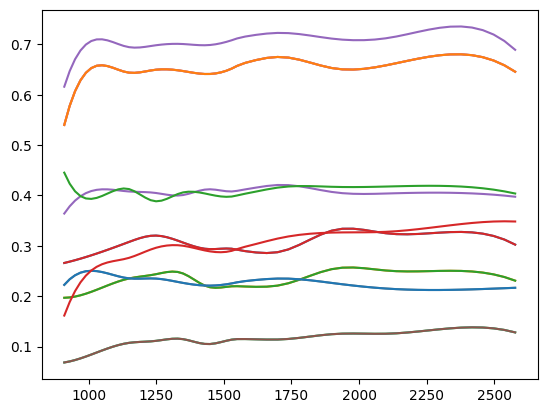

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from get_USGS_H2OFrost import get_USGS_H2OFrost
import numpy as np
df = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-2-23/sample_spectra.csv')
wvl_df = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-2-23/bandInfo.csv')
wvl = wvl_df.iloc[:,2]
_wvl,M = get_USGS_H2OFrost('D:/Data/USGS_Water_Ice')
for i in df.columns[1:]:
    I = np.array(df[i])
    plt.plot(wvl,I)
    #print (np.dot(I,M)/(np.linalg.norm(M)*np.linalg.norm(I)))
    print (180*(np.arccos(np.dot(df[i],M)/(np.linalg.norm(M)*np.linalg.norm(df[i])))/np.pi))

173, (0.02%)
(173, 59)


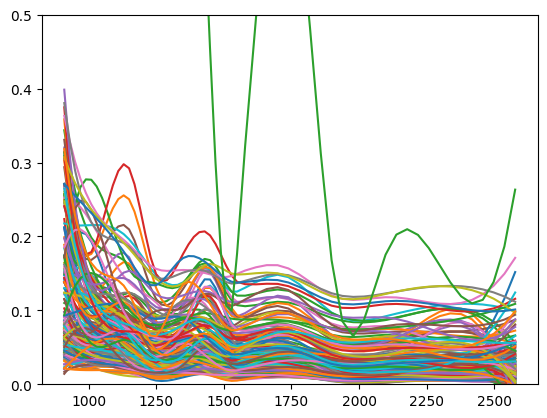

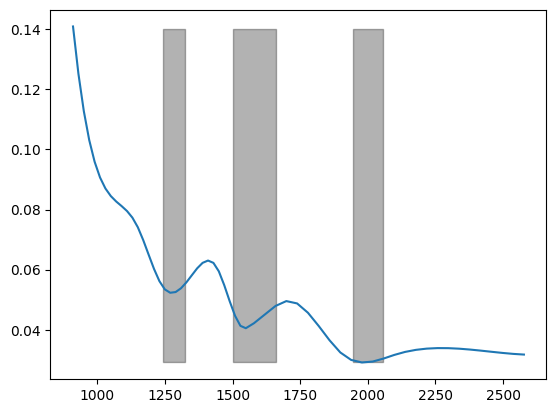

In [40]:
import tifffile as tf
smooth_im = tf.imread('D:/Data/Ice_Pipeline_Out_6-2-23/rfl_smooth/20090529t183825_smooth.tif')
df = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-2-23/detection_latlong.csv')
x,y = df['x'],df['y']
wvl_df = pd.read_csv('D:/Data/Ice_Pipeline_Out_6-2-23/bandInfo.csv')
wvl = wvl_df.iloc[:,2]
_wvl,M = get_USGS_H2OFrost('D:/Data/USGS_Water_Ice')

avg_arr = np.zeros((0,59))

num = 0
for i,j in zip(x,y):
    I = smooth_im[i,j,:]
    plt.plot(wvl,I)
    #print (180*(np.arccos(np.dot(I,M)/(np.linalg.norm(M)*np.linalg.norm(I)))/np.pi))
    avg_arr = np.concatenate([avg_arr,I[np.newaxis,:]])
    num+=1
plt.ylim(0,0.5)
print (f'{num}, ({num/smooth_im[:,:,0].size:.2%})')
print (avg_arr.shape)
fig = plt.figure()
avg = np.mean(avg_arr,axis=0)
plt.plot(wvl,avg)
plt.fill_betweenx(np.arange(avg.min(),avg.max(),0.001),1242,1323,color='k',alpha=0.3)
plt.fill_betweenx(np.arange(avg.min(),avg.max(),0.001),1503,1659,color='k',alpha=0.3)
plt.fill_betweenx(np.arange(avg.min(),avg.max(),0.001),1945,2056,color='k',alpha=0.3)

In [80]:
def stereo_project(lat:np.ndarray,long:np.ndarray)->np.ndarray:
    return np.array((2*1737400*np.tan(np.pi/4-np.pi*abs(lat/360))*np.sin(np.pi*long/180),\
            2*1737400*np.tan(np.pi/4-np.pi*abs(lat/360))*np.cos(np.pi*long/180)))
def stereo_project_float(lat:float,long:float)->tuple:
    return (2*1737400*np.tan(np.pi/4-np.pi*abs(lat/360))*np.sin(np.pi*long/180),\
            2*1737400*np.tan(np.pi/4-np.pi*abs(lat/360))*np.cos(np.pi*long/180))

smooth_im_backplane = tf.imread('D:/Data/Ice_Pipeline_Out_6-2-23/loc_cropped/m3g20090529t183825_loc_cropped.tif')
backplane_projected = np.moveaxis(stereo_project(smooth_im_backplane[:,:,1],smooth_im_backplane[:,:,0]),0,2)
print (backplane_projected.shape)

x_max,x_min,y_max,y_min = (backplane_projected[:,:,0].max(),backplane_projected[:,:,0].min(),backplane_projected[:,:,1].max(),backplane_projected[:,:,1].min())

with open('D:/Data/SP_IceLoc_280m.txt','r') as f:
    li_locations = f.readlines()
li_locations = [i[:-1] for i in li_locations]
li_locations = [i.split('\t') for i in li_locations]
li_locations = np.array(li_locations).astype(float)
li_locations_test = li_locations[np.where((li_locations[:,0]>x_min)&(li_locations[:,0]<x_max)&(li_locations[:,1]>y_min)&(li_locations[:,1]<y_max))]
print (li_locations_test)
plt.imshow(backplane_projected[:,:,0])
fig = plt.figure()
plt.imshow(backplane_projected[:,:,1])

(3333, 304, 2)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [55]:
lat = np.array(((-90,-80),(-70,-60)))
long = np.array(((0,90),(180,270)))
print (2*1737400*np.tan(np.pi/4-np.pi*abs(lat/360))*np.sin(np.pi*long/180))
print (np.dot(2*1737400*np.tan(np.pi/4-np.pi*abs(lat/360)),np.sin(np.pi*long/180)))

[[ 0.00000000e+00  3.04005608e+05]
 [ 7.50342309e-11 -9.31069854e+05]]
[[ 3.72299495e-11 -3.04005608e+05]
 [ 1.14023172e-10 -3.18368861e+05]]
